In [61]:
import pandas as pd
import math
import pandas as pd
import numpy as np
import sklearn.metrics as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import datasets
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import warnings
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer


warnings.filterwarnings(action='ignore')

data = []
with open('chronic_kidney_disease.arff', "r") as f:
    for line in f:
        line = line.replace('\n', '')
        data.append(line.split(','))


names = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba',
         'bgr', 'bu',  'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc',
         'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane',
         'class']
    
df = pd.DataFrame(data, columns=names)

In [62]:
df=df.replace('?', math.nan)
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,NaN,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [63]:
cols=['age','bp','sg','al','su','bgr','bu','sc','sod','pot','hemo','pcv','wbcc','rbcc']
for i in cols:
    df[i] = pd.to_numeric(df[i], errors='coerce')


In [64]:
# Extracting categorical and numerical columns
categorical_df=[]
numerical_df=[]
for col in df.columns:
    if df[col].dtype=='object':
        categorical_df.append(col)
    if df[col].dtype=='float64':
        numerical_df.append(col)

In [65]:
for col in categorical_df:
    print(f"{col} has {df[col].unique()} values\n")

rbc has [nan 'normal' 'abnormal'] values

pc has ['normal' 'abnormal' nan] values

pcc has ['notpresent' 'present' nan] values

ba has ['notpresent' 'present' nan] values

htn has ['yes' 'no' nan] values

dm has ['yes' 'no' ' yes' '\tno' nan] values

cad has ['no' 'yes' nan] values

appet has ['good' 'poor' nan] values

pe has ['no' 'yes' nan] values

ane has ['no' 'yes' nan] values

class has ['ckd' 'ckd\t' 'notckd'] values



In [66]:
# replace incorrect values

df['dm'].replace(to_replace = {'\tno':'no','\tyes':'yes',' yes':'yes'},inplace=True)

df['cad'] = df['cad'].replace(to_replace = '\tno', value='no')

df['class'] = df['class'].replace(to_replace = {'ckd\t': 'ckd', 'notckd': 'not ckd'})

In [67]:
df.isna().sum().sort_values(ascending = False)


rbc      152
rbcc     131
wbcc     106
pot       88
sod       87
pcv       71
pc        65
hemo      52
su        49
sg        47
al        46
bgr       44
bu        19
sc        17
bp        12
age        9
ba         4
pcc        4
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [68]:
categ_df=df[categorical_df]
normam_df=df[numerical_df]

In [69]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
dd=imputer.fit_transform(categ_df)
categ_df = pd.DataFrame(dd, columns = categorical_df)
categ_df.tail()

,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
395,normal,normal,notpresent,notpresent,no,no,no,good,no,no,not ckd
396,normal,normal,notpresent,notpresent,no,no,no,good,no,no,not ckd
397,normal,normal,notpresent,notpresent,no,no,no,good,no,no,not ckd
398,normal,normal,notpresent,notpresent,no,no,no,good,no,no,not ckd
399,normal,normal,notpresent,notpresent,no,no,no,good,no,no,not ckd


In [70]:
frames = [ categ_df,normam_df]
new_data=pd.concat(frames)
df = pd.concat([normam_df, categ_df], axis=1)

In [71]:
df.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,normal,notpresent,notpresent,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,normal,notpresent,notpresent,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,abnormal,present,notpresent,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,ckd


In [72]:
label_encoder = preprocessing.LabelEncoder()
for i  in categorical_df:
    df[i]= label_encoder.fit_transform(df[i])

In [73]:
df.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,1,0,0,1,1,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,1,0,0,0,1,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,0,1,0,1,0,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


<Figure size 432x288 with 0 Axes>

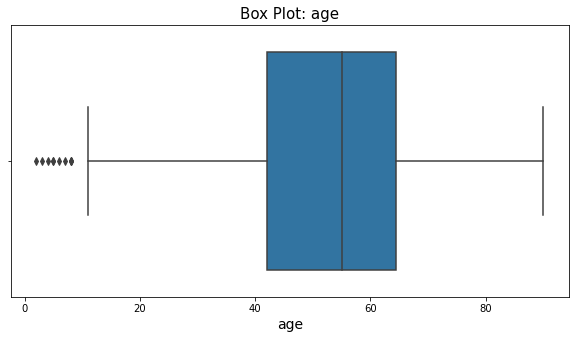

<Figure size 432x288 with 0 Axes>

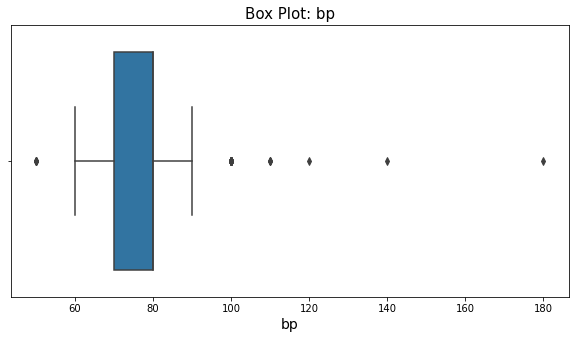

<Figure size 432x288 with 0 Axes>

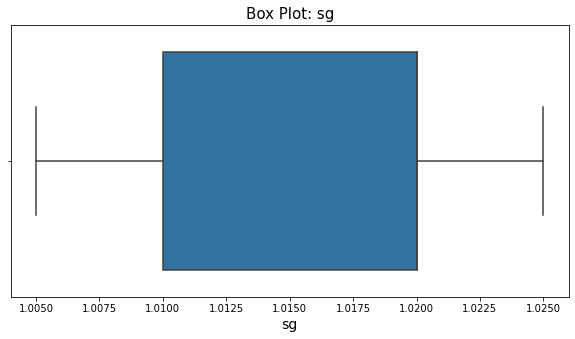

<Figure size 432x288 with 0 Axes>

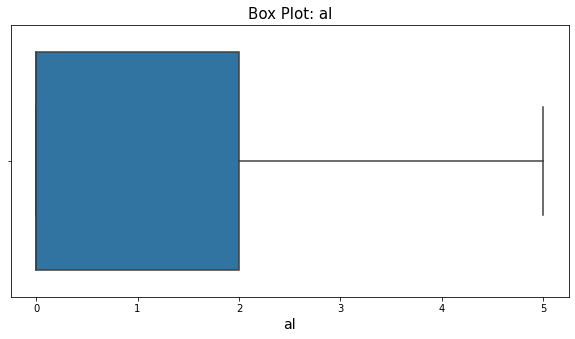

<Figure size 432x288 with 0 Axes>

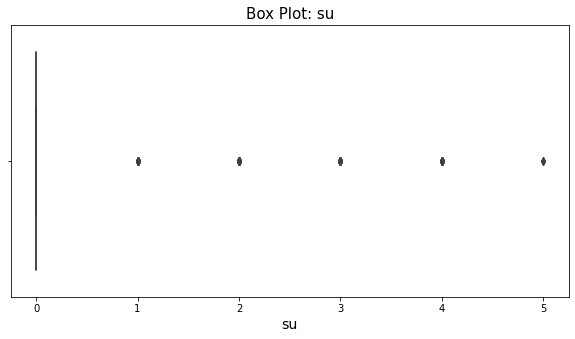

<Figure size 432x288 with 0 Axes>

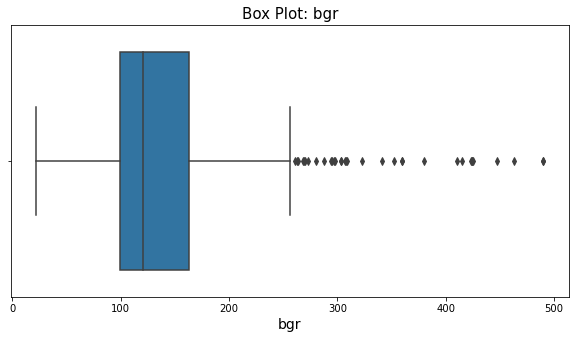

<Figure size 432x288 with 0 Axes>

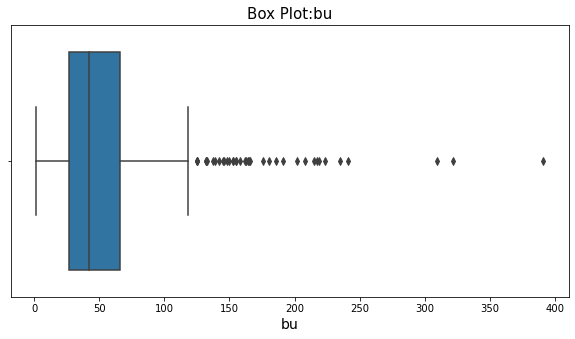

<Figure size 432x288 with 0 Axes>

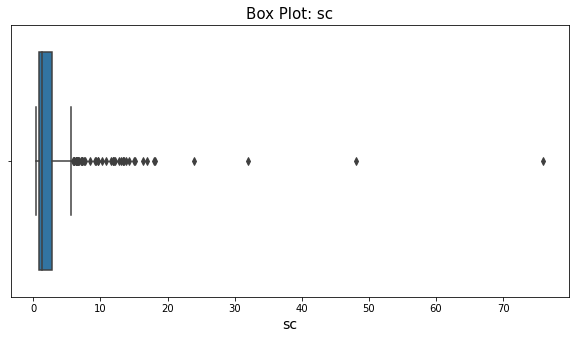

<Figure size 432x288 with 0 Axes>

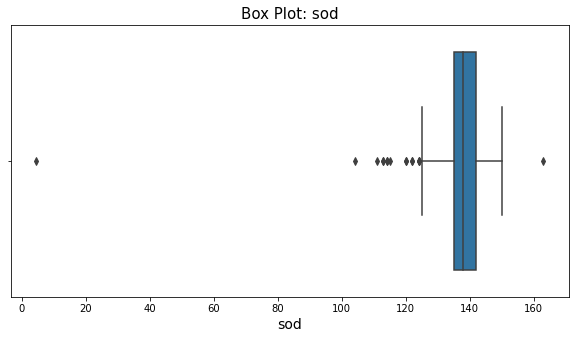

<Figure size 432x288 with 0 Axes>

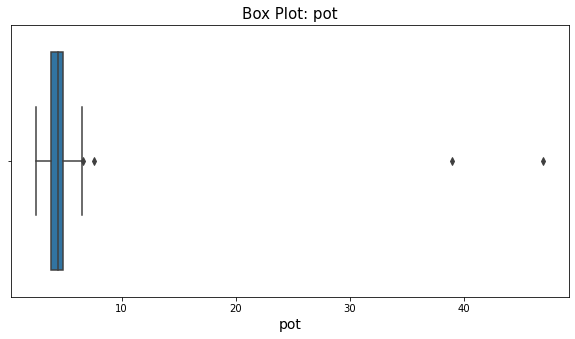

<Figure size 432x288 with 0 Axes>

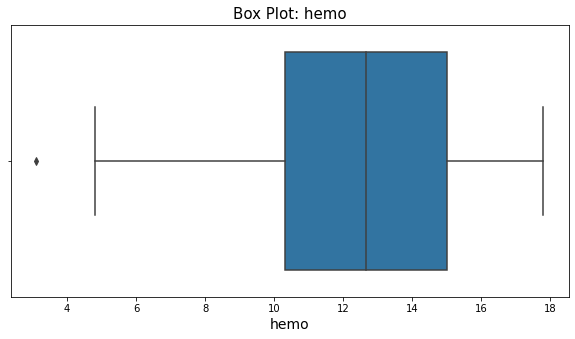

<Figure size 432x288 with 0 Axes>

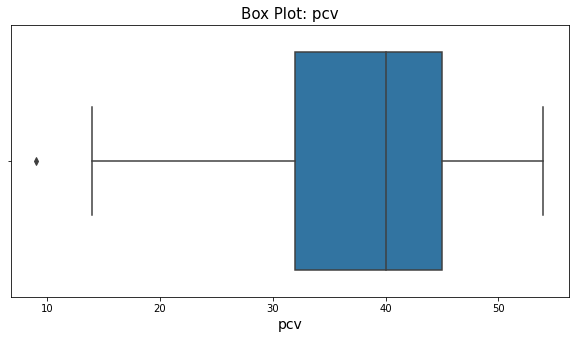

<Figure size 432x288 with 0 Axes>

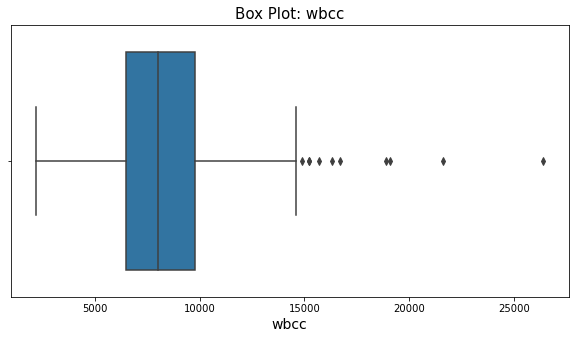

<Figure size 432x288 with 0 Axes>

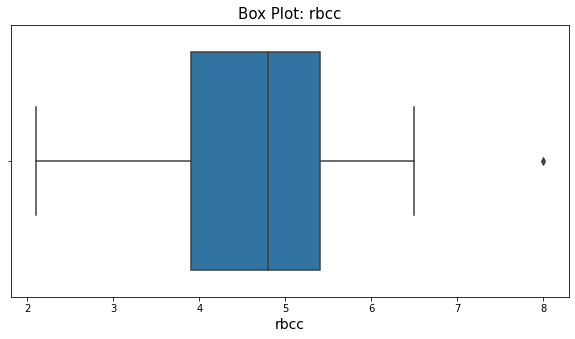

In [74]:
new_data=df
plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['age'])
plt.title('Box Plot: age', fontsize=15)
plt.xlabel('age', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['bp'])
plt.title('Box Plot: bp', fontsize=15)
plt.xlabel('bp', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['sg'])
plt.title('Box Plot: sg', fontsize=15)
plt.xlabel('sg', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['al'])
plt.title('Box Plot: al', fontsize=15)
plt.xlabel('al', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['su'])
plt.title('Box Plot: su', fontsize=15)
plt.xlabel('su', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['bgr'])
plt.title('Box Plot: bgr', fontsize=15)
plt.xlabel('bgr', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['bu'])
plt.title('Box Plot:bu', fontsize=15)
plt.xlabel('bu', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['sc'])
plt.title('Box Plot: sc', fontsize=15)
plt.xlabel('sc', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['sod'])
plt.title('Box Plot: sod', fontsize=15)
plt.xlabel('sod', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['pot'])
plt.title('Box Plot: pot', fontsize=15)
plt.xlabel('pot', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['hemo'])
plt.title('Box Plot: hemo', fontsize=15)
plt.xlabel('hemo', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['pcv'])
plt.title('Box Plot: pcv', fontsize=15)
plt.xlabel('pcv', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['wbcc'])
plt.title('Box Plot: wbcc', fontsize=15)
plt.xlabel('wbcc', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['rbcc'])
plt.title('Box Plot: rbcc', fontsize=15)
plt.xlabel('rbcc', fontsize=14)
plt.show()







In [75]:
features = ['age', 'sg', 'bgr', 'sc', 'sod',
       'pcv', 'wbcc', 'rbcc']
print(features)

def imput_ouliers(df,feature):
    q1 = np.percentile(df[feature],25)
    q3 = np.percentile(df[feature],75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    df.loc[df[feature] < lower_bound ,feature ] = lower_bound
    df.loc[df[feature] > upper_bound ,feature ] = upper_bound

['age', 'sg', 'bgr', 'sc', 'sod', 'pcv', 'wbcc', 'rbcc']


In [76]:
for feature in features:
    imput_ouliers(df,feature)
    


In [77]:
from sklearn.impute import KNNImputer

In [78]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [79]:
rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

In [80]:
df.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo',
       'pcv', 'wbcc', 'rbcc', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [81]:
def optimize_k(data, target):
    errors = []
    for k in range(1, 20):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)
        
        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})
        
    return errors

In [82]:
k_errors = optimize_k(data=df, target='class')
print(k_errors)

[{'K': 1, 'RMSE': 0.11558546621439911}, {'K': 2, 'RMSE': 0.13700729907563317}, {'K': 3, 'RMSE': 0.13947759676736618}, {'K': 4, 'RMSE': 0.13995356372740209}, {'K': 5, 'RMSE': 0.14117365193264642}, {'K': 6, 'RMSE': 0.16043067038443742}, {'K': 7, 'RMSE': 0.15600961508830152}, {'K': 8, 'RMSE': 0.15693629280698584}, {'K': 9, 'RMSE': 0.16147135968957468}, {'K': 10, 'RMSE': 0.1614032217770141}, {'K': 11, 'RMSE': 0.1605303709582707}, {'K': 12, 'RMSE': 0.15710187777362816}, {'K': 13, 'RMSE': 0.1628895331198417}, {'K': 14, 'RMSE': 0.15801582199260933}, {'K': 15, 'RMSE': 0.16}, {'K': 16, 'RMSE': 0.1681844225842572}, {'K': 17, 'RMSE': 0.1480135128966271}, {'K': 18, 'RMSE': 0.16228986413205232}, {'K': 19, 'RMSE': 0.16200617272190587}]


In [83]:
df.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,1,0,0,1,1,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,1,0,0,0,1,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,0,1,0,1,0,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [84]:
#akal wahda fiha error 1 donc bech nekhdmou knn bel 1
KNN=KNNImputer(weights='distance', n_neighbors=3)
data_after_knn=KNN.fit_transform(df)
df=pd.DataFrame(data_after_knn,columns=df.columns)


In [85]:
df.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.000000,36.0,1.2,138.794403,4.481559,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,7.0,50.0,1.020,4.0,0.0,107.005594,18.0,0.8,137.674750,3.773504,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,62.0,80.0,1.010,2.0,3.0,423.000000,53.0,1.8,132.000000,4.400633,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,48.0,70.0,1.005,4.0,0.0,117.000000,56.0,3.8,111.000000,2.500000,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
4,51.0,80.0,1.010,2.0,0.0,106.000000,26.0,1.4,138.031282,4.260403,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
# features = ['age', 'sg', 'bgr', 'sc', 'sod',
#        'pcv', 'wbcc', 'rbcc']
# print(features)

# def imput_ouliers(df,feature):
#     q1 = np.percentile(df[feature],25)
#     q3 = np.percentile(df[feature],75)
#     iqr = q3 - q1
#     lower_bound = q1 - 1.5*iqr
#     upper_bound = q3 + 1.5*iqr
#     df.loc[df[feature] < lower_bound ,feature ] = lower_bound
#     df.loc[df[feature] > upper_bound ,feature ] = upper_bound

In [87]:
# for feature in features:
#     imput_ouliers(df,feature)
    


# KNN

In [131]:

X =  df.drop(['class'], axis=1)
y = df['class']
#Diviser les données (80% Apprentissage et 20% Test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Text(0, 0.5, 'Erreur')

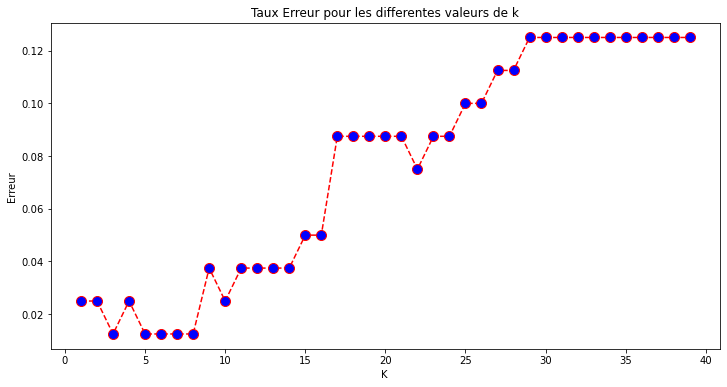

In [89]:
from sklearn.neighbors import KNeighborsClassifier

error = []
# Calculer l'erreur pour k entre 1 et 40 
#Pour chaque itération, l'err²eur moyenne pour les valeurs prédites 
#de l'ensemble de test est calculée et sauvegardée ds la liste Erreur.
# Tester k de 1 à 40 et la distance Manhattan
for i in range(1, 40):
    knn = KNeighborsClassifier(i,metric='manhattan')
    knn_model = knn.fit(X_train, y_train)
    pred_i = knn_model.predict(X_test)
    error.append(np.mean(pred_i != y_test))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Taux Erreur pour les differentes valeurs de k')
plt.xlabel('K ')
plt.ylabel('Erreur')

In [90]:
from sklearn.model_selection import GridSearchCV

n_neighbors = list(range(1,100))
p=[1,2] #p = 1 manhattan_distance/p=2 euclidean_distance
#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)

#cv: number of folds of the cross validation

#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best p: 2
Best n_neighbors: 2


In [91]:
# Afficher les paramètres qui donnent les meilleurs performances
best_parameters = clf.best_params_
print(best_parameters)

{'n_neighbors': 2, 'p': 2}


In [92]:
#Taux de bonne classification
best_result = clf.best_score_
print(best_result)

0.984375


In [93]:
knn = KNeighborsClassifier(2,p=2)
knn_model = knn.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

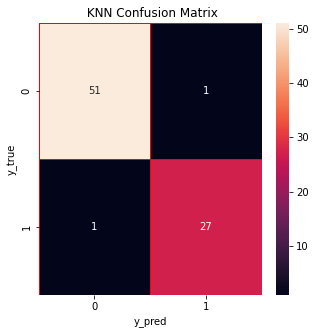

In [94]:
from sklearn.metrics import confusion_matrix
y_pred=knn.predict(X_test)
y_true=y_test
cm=confusion_matrix(y_true,y_pred)

#Confusion Matrix on Heatmap
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title(" KNN Confusion Matrix")
plt.show()


In [95]:
score=[] 
algorithms=[] 
precision=[]
sensitivity=[]
recall=[]
f1score=[]
from sklearn.metrics import precision_score,accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.metrics import sensitivity_score
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))
print("KNN precision =",precision_score(y_true, y_pred,average = 'macro')*100)
precision.append(precision_score(y_true, y_pred,average = 'macro')*100)

print("KNN sensitivity =",sensitivity_score(y_true, y_pred,average = 'macro')*100)
sensitivity.append(sensitivity_score(y_true, y_pred,average = 'macro')*100)

print("KNN recall =",recall_score(y_true, y_pred,average = 'macro')*100)
recall.append(recall_score(y_true, y_pred,average = 'macro')*100)

print("KNN f1 score =",f1_score(y_true, y_pred,average = 'binary')*100)
f1score.append(f1_score(y_true, y_pred,average = 'binary')*100)

Accuracy of K-NN classifier on test set: 0.97
KNN precision = 97.25274725274726
KNN sensitivity = 97.25274725274726
KNN recall = 97.25274725274726
KNN f1 score = 96.42857142857143


# SVM

In [96]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
support_vector_machine_model=SVC(random_state=0)
parameters_grid={'kernel':['rbf'],
                'C':[0.1]}
svm_grid_search=GridSearchCV(support_vector_machine_model,parameters_grid,scoring='accuracy')
svm_grid_search.fit(X_train,y_train)
svm_prediction=svm_grid_search.predict(X_test)
print('SVM prediction ='+str(metrics.precision_score(y_test,svm_prediction)))
print('SVM accurancy ='+str(metrics.accuracy_score(y_test,svm_prediction)))


print("SVM sensitivity =",sensitivity_score(y_test, svm_prediction,average = 'macro')*100)
sensitivity.append(sensitivity_score(y_test, svm_prediction,average = 'macro')*100)

print("SVM recall =",recall_score(y_test, svm_prediction,average = 'macro')*100)
recall.append(recall_score(y_test, svm_prediction,average = 'macro')*100)

print("SVM f1 score =",f1_score(y_test, svm_prediction,average = 'macro')*100)
f1score.append(f1_score(y_test, svm_prediction,average = 'macro')*100)


SVM prediction =0.9310344827586207
SVM accurancy =0.9625
SVM sensitivity = 96.29120879120879
SVM recall = 96.29120879120879
SVM f1 score = 95.91211037301993


# Decision Tree

In [132]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

# accuracy score, confusion matrix and classification report of decision tree

dtc_acc = accuracy_score(y_test, dtc.predict(X_test))

print(f"Training Accuracy of Decision Tree Classifier is {accuracy_score(y_train, dtc.predict(X_train))}")
print(f"Test Accuracy of Decision Tree Classifier is {dtc_acc} \n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, dtc.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, dtc.predict(X_test))}")

Training Accuracy of Decision Tree Classifier is 1.0
Test Accuracy of Decision Tree Classifier is 0.9625 

Confusion Matrix :- 
[[51  1]
 [ 2 26]]

Classification Report :- 
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97        52
         1.0       0.96      0.93      0.95        28

    accuracy                           0.96        80
   macro avg       0.96      0.95      0.96        80
weighted avg       0.96      0.96      0.96        80



# Random Forest

In [98]:
from sklearn.ensemble import RandomForestClassifier

rd_clf = RandomForestClassifier(criterion = 'entropy', max_depth = 11, max_features = 'auto', min_samples_leaf = 2, min_samples_split = 3, n_estimators = 130)
rd_clf.fit(X_train, y_train)

# accuracy score, confusion matrix and classification report of random forest

rd_clf_acc = accuracy_score(y_test, rd_clf.predict(X_test))

print(f"Training Accuracy of Random Forest Classifier is {accuracy_score(y_train, rd_clf.predict(X_train))}")
print(f"Test Accuracy of Random Forest Classifier is {rd_clf_acc} \n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, rd_clf.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, rd_clf.predict(X_test))}")

Training Accuracy of Random Forest Classifier is 0.996875
Test Accuracy of Random Forest Classifier is 0.975 

Confusion Matrix :- 
[[52  0]
 [ 2 26]]

Classification Report :- 
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        52
         1.0       1.00      0.93      0.96        28

    accuracy                           0.97        80
   macro avg       0.98      0.96      0.97        80
weighted avg       0.98      0.97      0.97        80



# ********************************************************************************RFE***********************************************************************************************

In [99]:
x=df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]]
y=df.iloc[:,24]

x.head()
# y.head()


from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
XTrain, XTest, YTrain, YTest = train_test_split(x,y, test_size=0.25, random_state=0)

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [100]:
clf_lr = LogisticRegression()
lr_base_line_model = clf_lr.fit(XTrain,YTrain)

In [101]:
rfe = RFE(estimator=clf_lr , step=1)
rfe = rfe.fit(XTrain,YTrain)

In [102]:
features2=['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo',
       'pcv', 'wbcc', 'rbcc', 'rbc: normal', 'pc: normal',
       'pcc: present', 'ba: present', 'htn: yes', 'dm: yes', 'cad: yes',
       'appet: poor', 'pe: yes', 'ane: yes']
selected_rfe_features = pd.DataFrame({'features2':list(XTrain.columns),
                                      'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,features2,Ranking
23,ane,1
21,appet,1
19,dm,1
3,al,1
4,su,1
18,htn,1
14,rbc,1
7,sc,1
13,rbcc,1
9,pot,1


In [103]:
from sklearn.svm import SVR, SVC, LinearSVC
from sklearn.feature_selection import RFECV,SelectFromModel
from sklearn.model_selection import StratifiedKFold

Optimal number of features : 15


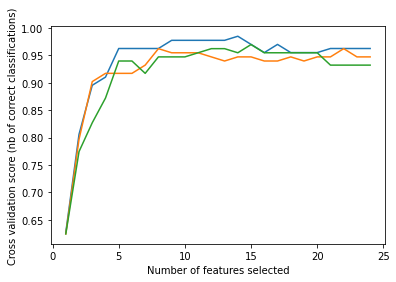

In [104]:

svc = SVC(kernel="linear")

rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(3),
              scoring='accuracy')
rfecv.fit(x, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plotting number of features and cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [105]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

x = df.drop(columns=['class'],axis=1)
y = df['class']

rfe = RFE(estimator=DecisionTreeClassifier(),n_features_to_select=15)
rfe.fit(x,y)

for i, col in zip(range(x.shape[1]),x.columns):
    print(f"{col} selected={rfe.support_[i]} rank={rfe.ranking_[i]}")
    
       

new_data.columns


age selected=False rank=10
bp selected=False rank=9
sg selected=True rank=1
al selected=True rank=1
su selected=False rank=2
bgr selected=True rank=1
bu selected=True rank=1
sc selected=True rank=1
sod selected=True rank=1
pot selected=True rank=1
hemo selected=True rank=1
pcv selected=True rank=1
wbcc selected=True rank=1
rbcc selected=True rank=1
rbc selected=True rank=1
pc selected=True rank=1
pcc selected=True rank=1
ba selected=True rank=1
htn selected=False rank=3
dm selected=False rank=4
cad selected=False rank=5
appet selected=False rank=6
pe selected=False rank=7
ane selected=False rank=8


Index(['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo',
       'pcv', 'wbcc', 'rbcc', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [106]:
#new_data_apres_RFE=df.drop(['age','bp','su','bgr','bu','pcv','wbcc','rbcc','rbc','dm','appet','pe','ane'], axis = 1)

new_data_apres_RFE=df.drop(['age','bp','su','pcv','wbcc','cad','dm','appet','pe','ane'], axis = 1)

# new_data_apres_RFE=df.drop(['al','sg','sod','pcc','cad','pc','pot','ba','age','bp','bgr','bu','wbcc'], axis = 1) #tab2



In [107]:
new_data_apres_RFE.columns

Index(['sg', 'al', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'rbcc', 'rbc',
       'pc', 'pcc', 'ba', 'htn', 'class'],
      dtype='object')

# Decision Tree + RFE

In [108]:
ind_col = [col for col in new_data_apres_RFE.columns if col != 'class']
dep_col = 'class'

X = new_data_apres_RFE[ind_col]
y = new_data_apres_RFE[dep_col]

In [109]:
print(y)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
395    1.0
396    1.0
397    1.0
398    1.0
399    1.0
Name: class, Length: 400, dtype: float64


In [110]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [111]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

# accuracy score, confusion matrix and classification report of decision tree
y_pred_dt=dtc.predict(X_test)

dtc_acc = accuracy_score(y_test, dtc.predict(X_test))

dtc_pre = precision_score(y_test, dtc.predict(X_test))

dtc_recal = recall_score(y_test, dtc.predict(X_test))

dtc_F1score = f1_score(y_test, dtc.predict(X_test))

print(f"Training Accuracy of Decision Tree Classifier is {accuracy_score(y_train, dtc.predict(X_train))}")
print(f"Test Accuracy of Decision Tree Classifier is {dtc_acc} \n")


print(f"Training precision of Decision Tree Classifier is {recall_score(y_train, dtc.predict(X_train))}")
print(f"Test precision of Decision Tree Classifier is {dtc_pre} \n")

print(f"Training recall of Decision Tree Classifier is {recall_score(y_train, dtc.predict(X_train))}")
print(f"Test recall of Decision Tree Classifier is {dtc_recal} \n")


print(f"Training f1_score of Decision Tree Classifier is {f1_score(y_train, dtc.predict(X_train))}")
print(f"Test f1_score of Decision Tree Classifier is {dtc_F1score} \n")


Training Accuracy of Decision Tree Classifier is 1.0
Test Accuracy of Decision Tree Classifier is 0.97 

Training precision of Decision Tree Classifier is 1.0
Test precision of Decision Tree Classifier is 1.0 

Training recall of Decision Tree Classifier is 1.0
Test recall of Decision Tree Classifier is 0.9210526315789473 

Training f1_score of Decision Tree Classifier is 1.0
Test f1_score of Decision Tree Classifier is 0.958904109589041 



# Random Forest + RFE

In [112]:
from sklearn.ensemble import RandomForestClassifier

In [113]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
tuned_parameters = [{'n_estimators':[7,8,9,10,11,12,13,14,15,16],'max_depth':[2,3,4,5,6,None],
                     'class_weight':[None,{0: 0.33,1:0.67},'balanced'],'random_state':[0]}]
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=10,scoring='f1')
clf.fit(X_train, y_train)
print("Detailed classification report:")
y_true, lr_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, lr_pred))
y_pred_rf=lr_pred
confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)


print('Best parameters:')
print(clf.best_params_)
clf_best = clf.best_estimator_

Detailed classification report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98        62
         1.0       1.00      0.92      0.96        38

    accuracy                           0.97       100
   macro avg       0.98      0.96      0.97       100
weighted avg       0.97      0.97      0.97       100

Confusion Matrix:
[[62  0]
 [ 3 35]]
Best parameters:
{'class_weight': None, 'max_depth': None, 'n_estimators': 8, 'random_state': 0}


# KNN + RFE 

In [114]:
#knn profa houni tebda l partie l behya 
X =  new_data_apres_RFE.drop(['class'], axis=1)
y = new_data_apres_RFE['class']
#Diviser les données (80% Apprentissage et 20% Test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Text(0, 0.5, 'Erreur')

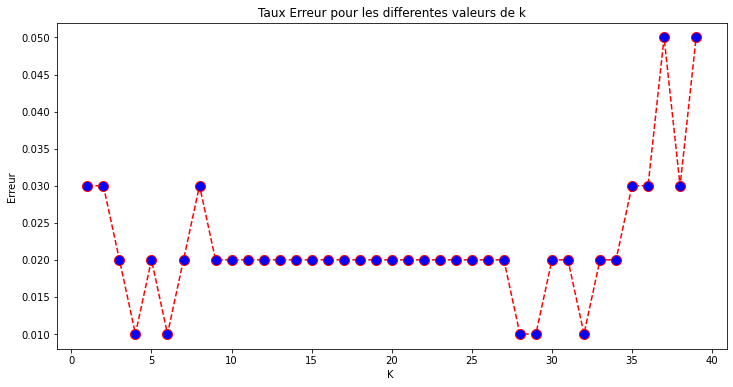

In [115]:
from sklearn.neighbors import KNeighborsClassifier

error = []
# Calculer l'erreur pour k entre 1 et 40 
#Pour chaque itération, l'err²eur moyenne pour les valeurs prédites 
#de l'ensemble de test est calculée et sauvegardée ds la liste Erreur.
# Tester k de 1 à 40 et la distance Manhattan
for i in range(1, 40):
    knn = KNeighborsClassifier(i,metric='manhattan')
    knn_model = knn.fit(X_train, y_train)
    pred_i = knn_model.predict(X_test)
    error.append(np.mean(pred_i != y_test))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Taux Erreur pour les differentes valeurs de k')
plt.xlabel('K ')
plt.ylabel('Erreur')

In [116]:
knn = KNeighborsClassifier(2,p=2)
knn_model = knn.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

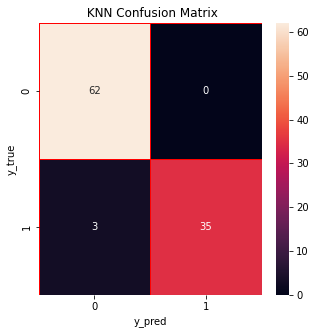

In [117]:
from sklearn.metrics import confusion_matrix
y_pred=knn.predict(X_test)
y_true=y_test
cm=confusion_matrix(y_true,y_pred)

#Confusion Matrix on Heatmap
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title(" KNN Confusion Matrix")
plt.show()


In [118]:
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))
print("KNN precision =",precision_score(y_true, y_pred,average = 'macro')*100)
precision.append(precision_score(y_true, y_pred,average = 'macro')*100)

print("KNN sensitivity =",sensitivity_score(y_true, y_pred,average = 'macro')*100)
sensitivity.append(sensitivity_score(y_true, y_pred,average = 'macro')*100)

print("KNN recall =",recall_score(y_true, y_pred,average = 'macro')*100)
recall.append(recall_score(y_true, y_pred,average = 'macro')*100)

print("KNN f1 score =",f1_score(y_true, y_pred,average = 'binary')*100)
f1score.append(f1_score(y_true, y_pred,average = 'binary')*100)

Accuracy of K-NN classifier on test set: 0.97
KNN precision = 97.69230769230771
KNN sensitivity = 96.05263157894737
KNN recall = 96.05263157894737
KNN f1 score = 95.8904109589041


# SVM + RFE 

In [119]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
support_vector_machine_model=SVC(random_state=0)
parameters_grid={'kernel':['rbf'],
                'C':[0.1]}
svm_grid_search=GridSearchCV(support_vector_machine_model,parameters_grid,scoring='accuracy')
svm_grid_search.fit(X_train,y_train)
svm_prediction=svm_grid_search.predict(X_test)
y_pred_svm=svm_prediction

print('SVM prediction ='+str(metrics.precision_score(y_test,svm_prediction)))
print('SVM accurancy ='+str(metrics.accuracy_score(y_test,svm_prediction)))


print("SVM sensitivity =",sensitivity_score(y_test, svm_prediction,average = 'macro')*100)
sensitivity.append(sensitivity_score(y_test, svm_prediction,average = 'macro')*100)

print("SVM recall =",recall_score(y_test, svm_prediction,average = 'macro')*100)
recall.append(recall_score(y_test, svm_prediction,average = 'macro')*100)

print("SVM f1 score =",f1_score(y_test, svm_prediction,average = 'macro')*100)
f1score.append(f1_score(y_test, svm_prediction,average = 'macro')*100)

SVM prediction =1.0
SVM accurancy =0.99
SVM sensitivity = 98.6842105263158
SVM recall = 98.6842105263158
SVM f1 score = 98.93333333333332


# Model Compar

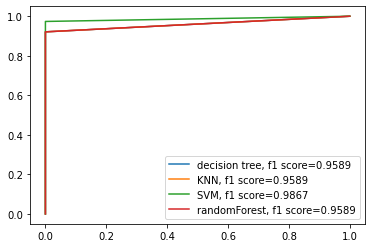

In [120]:
plt.figure(0).clf()

#fit tree model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_dt)
auc = round(metrics.f1_score(y_test, y_pred_dt), 4)
plt.plot(fpr,tpr,label="decision tree, f1 score="+str(auc))

#fit KNN model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_knn)
auc = round(metrics.f1_score(y_test, y_pred_knn), 4)
plt.plot(fpr,tpr,label="KNN, f1 score="+str(auc))

#fit SVM model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_svm)
auc = round(metrics.f1_score(y_test, y_pred_svm), 4)
plt.plot(fpr,tpr,label="SVM, f1 score="+str(auc))

#fit SVM model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_rf)
auc = round(metrics.f1_score(y_test, y_pred_rf), 4)
plt.plot(fpr,tpr,label="randomForest, f1 score="+str(auc))
#add legend
plt.legend()

# how decision tree works

In [122]:
from sklearn import tree

X_dtr = new_data_apres_RFE.drop(['class'], axis=1)
y_dtr = new_data_apres_RFE['class']
clf = DecisionTreeClassifier(random_state=1234)
model_dtr = clf.fit(X_dtr, y_dtr)


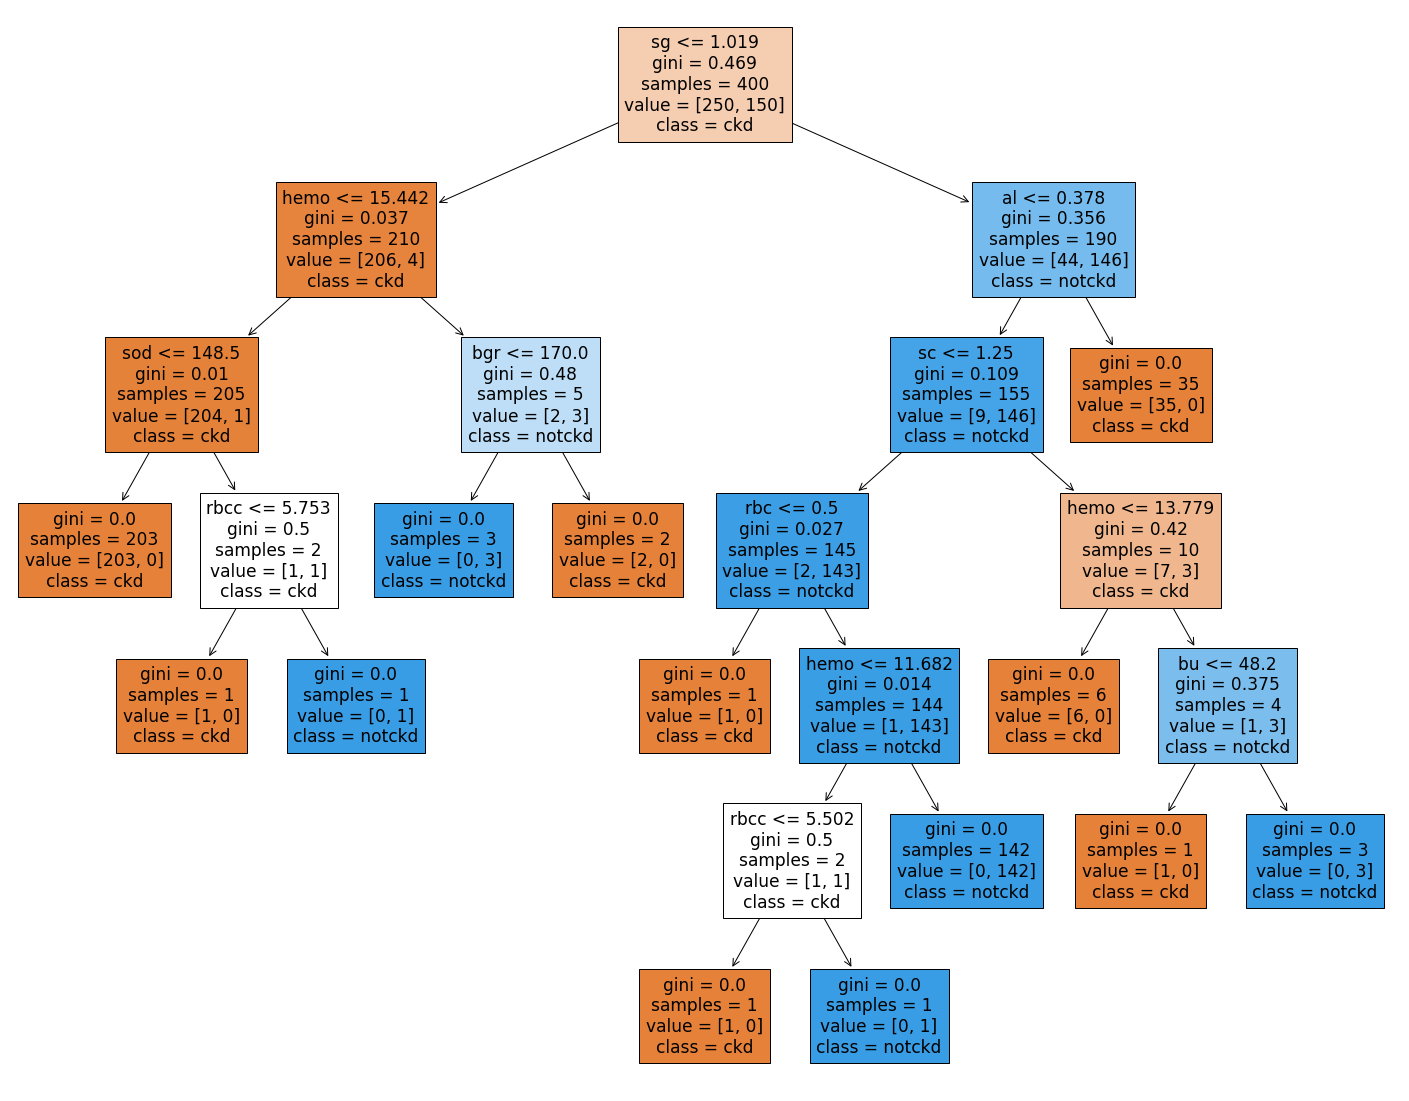

In [123]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=new_data_apres_RFE.columns,
                   class_names=['ckd','notckd'],
                   filled=True)

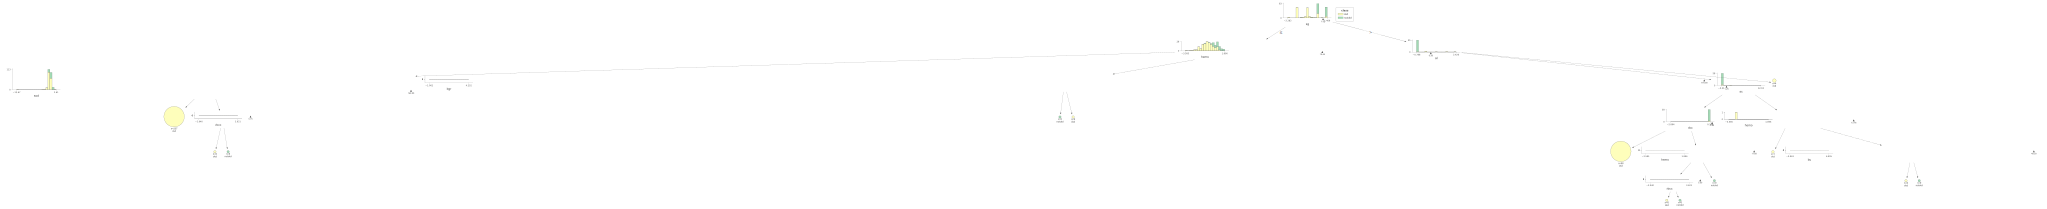

In [126]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(clf,X_train,y_train,
                target_name="class",
                feature_names=new_data_apres_RFE.columns,
                class_names=list(['ckd','notckd']))

viz